# EPSRC: AI Skills Through Music 🤖🎹



## 1: Data Representations 📊

If you've used AI in the past, you might have played around with models like ChatGPT, Claude, or Grok. These models can generate a variety of different things, like audio, images, text, and videos. But they don't work with audio, images, or text directly. Instead, these are converted into numerical **representations**. These representations may take the form of one-dimensional sequences such as lists and arrays, or higher-dimensional matrices.

This notebook introduces a variety of different methods for representing text, audio, and images. While we **don't look at specific AI techniques or skills just yet**, the concepts introduced here are absolutely *fundamental* to the study of machine learning.

In [132]:
import librosa
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.fft
import IPython.display as ipd
import skimage
import torch
import torchaudio
from transformers import EncodecModel, AutoProcessor

np.set_printoptions(suppress=True)

## Representing Text 📚

Chatbots like ChatGPT and Claude are probably best known for their ability to generate text. You can provide these models with your own **input text** (that might be a question, or some text to summarize), and they'll respond with **output text**. These models are sometimes also called *large language models* (LLMs).

But be warned, the answer might not always be correct, like when we asked ChatGPT how many "R's" are in the word `strawberry` 🍓

<img src="https://prompt.16x.engineer/nextImageExportOptimizer/wrong-answer.4536ac48-opt-1920.WEBP" alt="ChatGPT answering a question incorrectly" width="500px"/>

💥💥💥

Later on in this notebook, we'll learn **exactly why** ChatGPT got this question wrong.


*If you haven't used a chatbot or LLM yourself, you can use the interactive code cell below to chat directly with ChatGPT. Just type in your text and hit the "Play" button to get a response. What do you notice about the sorts of questions it is able to answer?*

In [133]:
# Interactive OpenAI component goes here

### Seq2Seq Models 🤖

These types of model are usually known as **sequence to sequence (seq2seq) models**. This means that they take in one sequence, transform it, and respond with another sequence. LLMs are a type of **seq2seq** model, but there are others too, as we'll explore further on in this notebook.

But how can we represent text and language as a sequence? One straightforward option is to treat every word in the text as a separate member of the sequence:

In [134]:
input_text = "the quick brown fox jumped over the lazy dog"
text_sequence = input_text.split(" ")
print(text_sequence)

['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']


In this case, our input sequence has one dimension and is **ordered**, with the same word able to appear in multiple places.

This distinguishes it from other mathematical concepts like a **set**, which is typically unordered and disallows duplicates.

#### Autoregression ⏩

A typical seq2seq model like a chatbot or LLM is trained to predict the next member of an input sequence by considering only the previous members.

Let's use our input sequence from above to show how this works:

In [135]:
for idx in range(1, len(text_sequence)):
    print(f"Step {idx}")
    print(f"Model input: '{' '.join(text_sequence[:idx])}'")
    print(f"Model predicted output: {text_sequence[idx]}")
    print("\n")

Step 1
Model input: 'the'
Model predicted output: quick


Step 2
Model input: 'the quick'
Model predicted output: brown


Step 3
Model input: 'the quick brown'
Model predicted output: fox


Step 4
Model input: 'the quick brown fox'
Model predicted output: jumped


Step 5
Model input: 'the quick brown fox jumped'
Model predicted output: over


Step 6
Model input: 'the quick brown fox jumped over'
Model predicted output: the


Step 7
Model input: 'the quick brown fox jumped over the'
Model predicted output: lazy


Step 8
Model input: 'the quick brown fox jumped over the lazy'
Model predicted output: dog




At every step, we train the model to predict the next member of the sequence by using the previous members as context.

This type of prediction is called **autoregressive prediction**.

#### Generating New Text ✨

When we want to **generate new text** with our model, we can just continue the autoregressive process beyond the length of the input sequence by appending the model's generation to the sequence and then predicting the next member using it.

Let's imagine that our model has just predicted the word `dog` in the sequence above. What words might follow it? We might expect any of the following:
- `then`
- `and`
- `after`
- `before`
- ...

The model then chooses the most likely option from its entire vocabulary and appends this to the sequence. So, we could end up with:

`The quick brown fox jumped over the lazy dog **and**`

We can then repeat the process for as long as we want to keep generating text.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*dh2V-HEexegCO8nPX5VR4g.gif" alt="Autoregression GIF" width="500px"/>

### Self-Supervised Learning 🧠

We often call this type of autoregressive prediction **self-supervised learning**. The model does not have an explicit **class** or **label** that it is trying to predict. Instead, this comes directly from the input.

Self-supervised learning is highly **scalable**. We can use theoretically any text to train our chatbot: including the text you're reading right now! In fact, it is often this very reason [why generative AI has proven so controversial](https://www.hollywoodreporter.com/business/business-news/george-rr-martin-openai-court-legal-1236413461/), especially when the text used during training is copyrighted.

Regardless, autoregression and self-supervised learning are clearly powerful tools in the AI scientist's toolbox. We can also use autoregression in other contexts, beyond generating text.

One common example is **forecasting** time-series data, such as the exchange rate between two currencies or the temperature in a particular location. The same principles apply here: we use our past values as context to predict future values.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTGZ_Ip62DQlU1nXH7Lr2Yrngo3kUiiBXiVnA&s" alt="Time-Series Forecasting" width="400px"/>



### Model Vocabulary 📘

Under the hood, our chatbots don't work directly using words. Instead, they convert the members of an input text sequence to **numerical values**. Each value corresponds with one unique item in the model's **vocabulary**. In our case, if the same word appears twice in the sentence, it will map onto the same value.

Let's try generating a vocabulary using our text sequence above.

In [136]:
# Note that we use "set(...)" to remove duplicates in the sequence
#  so that we only count each unique word once
vocabulary = {k: n for n, k in enumerate(sorted(set(text_sequence)))}
print(vocabulary)

{'brown': 0, 'dog': 1, 'fox': 2, 'jumped': 3, 'lazy': 4, 'over': 5, 'quick': 6, 'the': 7}


Now, we can map our text sequence onto the vocabulary. We can see how the word `the` maps onto the value `7` both times:

In [137]:
sequence_mapped = [vocabulary[k] for k in text_sequence]
print(sequence_mapped)

[7, 6, 0, 2, 3, 5, 7, 4, 1]


We can go back the other way too, and transform the numerical values in `sequence_mapped` back onto the original text:

In [138]:
vocabulary_inverted = {v: k for k, v in vocabulary.items()}
text_sequence_reconstructed = [vocabulary_inverted[v] for v in sequence_mapped]
print(text_sequence_reconstructed)

['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']


Let's repeat the same process of generating a vocabulary, but with a larger text input this time. We'll use the famous opening lines from Franz Kafka's book [**The Metamorphosis**](https://en.wikipedia.org/wiki/The_Metamorphosis).

In [139]:
kafka = """
One morning, when Gregor Samsa woke from troubled dreams, he found himself
transformed in his bed into a horrible vermin. He lay on his armour-like back,
and if he lifted his head a little he could see his brown belly, slightly domed
and divided by arches into stiff sections. The bedding was hardly able to cover
it and seemed ready to slide off any moment. His many legs, pitifully thin
compared with the size of the rest of him, waved about helplessly as he looked.
"What's happened to me?" he thought. It wasn't a dream. His room, a proper
human room although a little too small, lay peacefully between its four
familiar walls.
"""

# Convert the text to lower case, remove newline characters (\n), and split into words
kafka_split = kafka.lower().replace("\n", "").split(" ")
kafka_vocabulary = {k: n for n, k in enumerate(sorted(set(kafka_split)))}
print(len(kafka_vocabulary))

88


Whoa! We can see that the size of our vocabulary has increased pretty dramatically with just a slightly larger text input.

In order to represent every word that a user could ever use, our chatbot will need an even larger vocabulary than this one. In fact, there are over **800,000 words in the [English dictionary alone](https://en.wikipedia.org/wiki/List_of_dictionaries_by_number_of_words)**. With so many options available to choose from, it might become hard for our model to choose the correct word from its vocabulary.

### Tokenisation 🔤

**Tokenisation** is one method that ML scientists can use to address this problem. Tokenisation is how chatbots break down text into smaller, manageable units for processing.

When we type text into ChatGPT, it converts our text into tokens, predicts the next token, then converts this **back into text**.

#### Simple Tokenisation with Characters 🔡

Perhaps the most simplistic method of tokenisation is just to use individual letters and characters, rather than whole words.

So, rather than representing the word `and` as a single token, we can represent the letters `['a', 'n', 'd']` as separate tokens. This will mean that we repeat the same token much more often.

Let's try tokenising our input text in this way:


In [140]:
kafka_split_letters = list(kafka.lower().replace("\n", ""))
kafka_vocabulary_letters = {k: n for n, k in enumerate(sorted(set(kafka_split_letters)))}
print(len(kafka_vocabulary_letters))

30


**Nice!** By splitting our text not into words, but letters, we've reduced the size of our vocabulary by over half.

The reconstructed text looks the same as the original, too:

In [141]:
kafka_tokenized = [kafka_vocabulary_letters[k] for k in kafka_split_letters]
print("Text represented as tokens: ")
print(kafka_tokenized)

Text represented as tokens: 
[20, 19, 11, 0, 18, 20, 22, 19, 15, 19, 13, 3, 0, 27, 14, 11, 19, 0, 13, 22, 11, 13, 20, 22, 0, 23, 7, 18, 23, 7, 0, 27, 20, 16, 11, 0, 12, 22, 20, 18, 0, 24, 22, 20, 25, 8, 17, 11, 10, 0, 10, 22, 11, 7, 18, 23, 3, 0, 14, 11, 0, 12, 20, 25, 19, 10, 0, 14, 15, 18, 23, 11, 17, 12, 0, 24, 22, 7, 19, 23, 12, 20, 22, 18, 11, 10, 0, 15, 19, 0, 14, 15, 23, 0, 8, 11, 10, 0, 15, 19, 24, 20, 0, 7, 0, 14, 20, 22, 22, 15, 8, 17, 11, 0, 26, 11, 22, 18, 15, 19, 5, 0, 14, 11, 0, 17, 7, 28, 0, 20, 19, 0, 14, 15, 23, 0, 7, 22, 18, 20, 25, 22, 4, 17, 15, 16, 11, 0, 8, 7, 9, 16, 3, 0, 7, 19, 10, 0, 15, 12, 0, 14, 11, 0, 17, 15, 12, 24, 11, 10, 0, 14, 15, 23, 0, 14, 11, 7, 10, 0, 7, 0, 17, 15, 24, 24, 17, 11, 0, 14, 11, 0, 9, 20, 25, 17, 10, 0, 23, 11, 11, 0, 14, 15, 23, 0, 8, 22, 20, 27, 19, 0, 8, 11, 17, 17, 28, 3, 0, 23, 17, 15, 13, 14, 24, 17, 28, 0, 10, 20, 18, 11, 10, 0, 7, 19, 10, 0, 10, 15, 26, 15, 10, 11, 10, 0, 8, 28, 0, 7, 22, 9, 14, 11, 23, 0, 15, 19, 24, 20, 0, 23

In [142]:
letters_vocab_inv = {v: k for k, v in kafka_vocabulary_letters.items()}
kafka_reconstructed = "".join([letters_vocab_inv[v] for v in kafka_tokenized])
print(f"Text reconstructed from tokens: ")
print(kafka_reconstructed)

Text reconstructed from tokens: 
one morning, when gregor samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. he lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections. the bedding was hardly able to cover it and seemed ready to slide off any moment. his many legs, pitifully thin compared with the size of the rest of him, waved about helplessly as he looked. "what's happened to me?" he thought. it wasn't a dream. his room, a proper human room although a little too small, lay peacefully between its four familiar walls.


There are many different ways of tokenizing text, beyond just using individual letters. Most large language models like ChatGPT use much more complicated methods of tokenisation. Popular options include [Byte-Pair Encoding](https://huggingface.co/learn/llm-course/en/chapter6/5) and [WordPiece](https://huggingface.co/learn/llm-course/en/chapter6/6). Many of these methods (including BPE) start by first splitting text into its respective letters and characters, however.

OpenAI have released a [Tokenizer Playground](https://platform.openai.com/tokenizer) that you can use to understand how a piece of text might be tokenized by ChatGPT.

#### Problems with Representing Text as Tokens 🍓

Tokenisation is a powerful process that allows a model to learn a large and diverse vocabulary. But it can also lead to pitfalls, too, like in the first example we gave of ChatGPT not being able to count the number of "r"s in the word `strawberry`.

<img src="https://prompt.16x.engineer/nextImageExportOptimizer/wrong-answer.4536ac48-opt-1920.WEBP" alt="ChatGPT answering a question incorrectly" width="400px"/>


This is because ChatGPT tokenises the word `strawberry` into three distinct parts: `['str', 'aw', 'berry']`.

<img src="https://prompt.16x.engineer/nextImageExportOptimizer/tokenization.08243a7b-opt-1920.WEBP" alt="Strawberry Tokenization" width="400px"/>


These get converted into the numerical values `[496, 675, 15717]`.

<img src="https://prompt.16x.engineer/nextImageExportOptimizer/tokenization-id.c68c9dbf-opt-1920.WEBP" width="400px"/>


So, from ChatGPT's perspective, it cannot count the R's in `strawberry` because it is not processing the word `strawberry`. Neither is it processing the individual letters **in** `strawberry`. Instead, it is simply processing the sequence of three numerical values `[496, 675, 15717]`.

### Special Tokens 🔠

We've seen now how tokens can map onto *individual letters* or *groups of letters*. Under the hood, our model converts input text into tokens, predicts the next token autoregressively, and converts this back into text.

But tokens don't need to be restricted to just text. We can also use *special tokens* to pass instructions and additional information to our model. Unlike normal tokens, these special tokens are not converted into text that is shown to the user.

There are many types of *special token* that we can use.

#### `<STOP>` Tokens 🛑

One example is called a `<STOP>` token, sometimes also referred to as an `<EOS>` (end of sequence) token.

When generating text, our model could theoretically continue predicting the next token forever (or, at least, until it runs out of memory and crashes 🔥). Usually, however, we'll want the model to stop generating after a certain period of time. That's where a `<STOP>` token comes in.

We can add the `<STOP>` token into our training data and vocabulary like so:

In [143]:
kafka_stop = kafka_split_letters + ["<STOP>"]
kafka_vocabulary_letters["<STOP>"] = len(kafka_vocabulary_letters)

Now, if we tokenize our text, we can see that we've added an additional token at the very end:

In [144]:
kafka_stop_tokenized = [kafka_vocabulary_letters[k] for k in kafka_stop]
print(kafka_stop_tokenized[-30:])

letters_vocab_inv = {v: k for k, v in kafka_vocabulary_letters.items()}
kafka_reconstructed = "".join([letters_vocab_inv[v] for v in kafka_stop_tokenized[-30:]])
print(f"Text reconstructed from tokens: ")
print(kafka_reconstructed)

[27, 11, 11, 19, 0, 15, 24, 23, 0, 12, 20, 25, 22, 0, 12, 7, 18, 15, 17, 15, 7, 22, 0, 27, 7, 17, 17, 23, 5, 30]
Text reconstructed from tokens: 
ween its four familiar walls.<STOP>


If we train our LLM on text using the `<STOP>` token, it should learn to output this token at the end of a response.

We can then add some logic into our **backend code** (the code that runs on the server and which receives requests from the user) to **stop autoregression** as soon as we receive a `<STOP>` token from the model.

And that's how ChatGPT knows when to *stop talking* to you!

#### Other Types of Special Token

There are many other types of special token that we might use . Here are a few examples: what do you think they might do, and where would we add them to the text?

- `<START>` (or `<BOS>`)
- `<PAD>`
- `<SYSTEM>`
- `<ASSISTANT>`

## Representing Audio 🎵

We've now seen how text can be represented as sequences of **numerical values** and **tokens** that can be predicted using **autoregression** and **self-supervised learning**.

Can you think of any other types of input that could be represented with **tokens**?

One possibility is **music** and **audio**!

### Using MIDI 🎹

One common way of representing musical audio for machine learning models is using the [**MIDI** standard](https://en.wikipedia.org/wiki/MIDI), which is short for Musical instrument Digital Interface.

MIDI data can be stored in computer files or can be generated by special instruments such as a **synthesizer**

<img src="https://m.media-amazon.com/images/I/717qmGlA7ZL.jpg" width="400px"/>




MIDI messages encode information for each note, including the following details:

- The **note number** is an integer between 0 and 127 that encodes the note's pitch. Larger values are higher pitches.
- The **key velocity** is an integer between 0 and 127 which controls the volume of the sound. Larger values are louder.
- The **channel** is an integer between 0 and 15 which prompts the synthesizer to use a specific instrument.

MIDI can also encode tempo in terms of the number of **beats per minute** (BPM).

#### Creating a MIDI vocabulary 📘

With this information, we can try creating a vocabulary of MIDI tokens.

We'll also add `WAIT_XXSECONDS` tokens that we can use to separate notes with a rest.

In [145]:
midi_notes = [f"NOTE_{i}" for i in range(127)]
midi_velocities = [f"VELOCITY_{i}" for i in range(127)]
midi_channels = [f"CHANNEL_{i}" for i in range(16)]
midi_rests = [f"WAIT_{i}SECONDS" for i in range(5)]

midi_vocabulary = {
    k: v for v, k in enumerate(midi_notes + midi_velocities + midi_channels + midi_rests)
}
print(len(midi_vocabulary))

275


Let's try creating an example sequence in a format close to actual MIDI:

In [146]:
midi_sequence = [
    "CHANNEL_7",
    "NOTE_60", "VELOCITY_50", "WAIT_1SECONDS",
    "NOTE_65", "VELOCITY_45", "WAIT_1SECONDS",
    "NOTE_60", "VELOCITY_50", "WAIT_2SECONDS"
]
midi_tokenized = [midi_vocabulary[k] for k in midi_sequence]
print(midi_tokenized)

[261, 60, 177, 271, 65, 172, 271, 60, 177, 272]


Notice how similar our MIDI sequence is to our text sequence from earlier? In fact, many state-of-the-art music generation models are [simply seq2seq models that are trained on MIDI](https://arxiv.org/pdf/2501.17011), not text! The **exact same principles** of autoregression and self-supervised learning apply in these cases.

Watch the video below for an example of acclaimed keyboardist [Jordan Rudess](https://en.wikipedia.org/wiki/Jordan_Rudess) performing live with the `jam_bot`. Rudess plays live on a MIDI synthesizer; the notes he plays are sent to the `jam_bot`, which responds in real-time with its own MIDI.

For more information on the `jam_bot`, you can read the [paper by the authors](https://ismir2025program.ismir.net/poster_321.html).

In [147]:
ipd.HTML('''
<iframe width="560" height="315"
src="https://www.youtube.com/embed/kWKWoL9JKqY"
referrerpolicy="strict-origin-when-cross-origin"
</iframe>
''')

### Using Waveforms 🔊

We call MIDI a **symbolic representation** as it is based on a finite, discrete alphabet of symbols. It encodes exact details such as note parameters and durations that can be used to reproduce a musical performance. For this reason, *MIDI converts very well into tokens.*

However, most of the music that you listen to is probably not represented in MIDI! Instead, we are likely to be more familiar with **audio signals** and recordings. Unlike sheet music or symbolic representations, audio signals **encode everything that is necessary** to reproduce an acoustic realization of a piece of music.

#### Waveforms 🏄

In essence, sound is simply air vibrating. An audio signal, then, **represents the fluctuation in air pressure caused by the vibration as a function of time**.

We can graphically represent the change in air pressure caused by a vibration at a certain point in time using a pressure-time plot. This is more commonly known as a **waveform**, and you've probably seen one before:

<img src="https://media.wired.com/photos/65e8385a7e55097b1dfa6ac1/master/w_1600%2Cc_limit/iStock-500703366.jpg" width="400px"/>

Let's load up an audio file. We'll use the `librosa` library to do this.

In [148]:
y, sr = librosa.load(librosa.example("choice"), duration=10, sr=24000)
ipd.Audio(y, rate=sr)

We can produce a waveform for an audio signal directly in Python by plotting the signal.

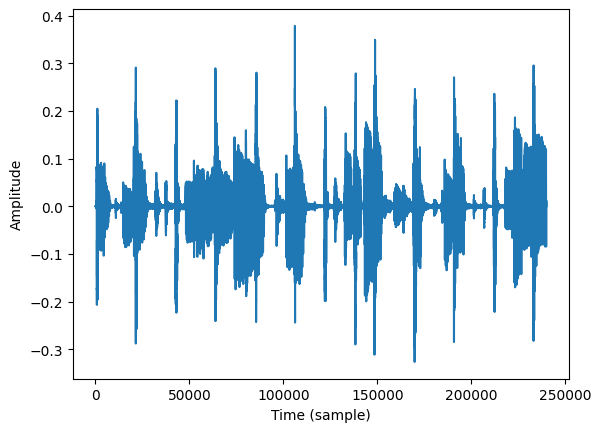

In [149]:
plt.plot(y)
plt.gca().set(xlabel="Time (sample)", ylabel="Amplitude")
plt.show()

Notice how there are strong *peaks* in this graph. Try listening to the audio again, and think about what instruments they correspond with.


#### Sample Rate 🔢


When working with audio, we often measure time in the **samples**. Let's print out the first ten samples of our waveform.


In [150]:
print(y[:10])

[ 0.00001088  0.00000053  0.00000583 -0.00002531 -0.00001066  0.000033
 -0.00001622 -0.00001281 -0.00001602 -0.00002688]


We measure the number of samples in a single second using the "sample rate" (sometimes abbreviated as `sr`).

Let's print out the sample rate of our audio:

In [151]:
print(sr)

24000


Pretty large! That means that we have 24000 samples **per second of audio**. Using standard 32-bit floating point precision, it'd require approximately **1 megabyte of memory** to represent 10 seconds of audio at this sample rate.

A large sample rate means that audio represented using a waveform can be quite computationally intensive and **dense**. We need a long sequence just to represent a small chunk of audio.

<img src="https://jvbalen.github.io/figs/rick.gif" alt="Zooming into an audio file" width="500px"/>

Standard sample rates include:
- 44100 Hz (44.1 kHz): the standard sample rate for **CD-quality** audio
- 48000 Hz (48 kHz): the standard sample rate for **DVD-quality** audio.
- 96000 Hz (96 kHz): double the rate of 48 kHz, common in **high-resolution audio** but rarer in everyday listening.
- 22050 Hz: half the rate of CD-quality audio. Common in machine learning contexts.

Note that humans cannot easily hear the difference between 48 and 44.1 kHz sampling rates. One benefit of the lower value is that audio encoded as 44.1 kHz usually has a **smaller file size**, simply because it has fewer samples per second.

### Tokenization and Audio Signals

Much like our text and MIDI sequences above, our waveform representation is also a **one-dimensional, ordered sequence**. But this time, each member of the sequence are **continuous**, rather than discrete: they can take *any value*, corresponding with the change in air pressure at a particular sample.

This means that it is *much more complicated* to tokenize an audio waveform compared with MIDI or text. One possibility is to convert the continuous audio signal into a sequence of discrete elements. There are many different ways of doing this.

<img src="https://ravinkumar.com/GenAiGuidebook/_images/tokenization_simplified.png" width="600px"/>

#### Vector Quantization

One popular example is **vector quantization (VQ)**. In a VQ-based system:

- high-level features are extracted from short segments of audio
- we construct a codebook (similar to a dictionary in Python) that maps these features to their nearest neighbour or centroid in the codebook
- we assign every centroid a unique token
- the initial audio is represented as a sequence of these tokens.

In the example below, **black circles** represent the input features extracted from the audio, and **red squares** represent the centroids which we assign tokens to. The **blue lines** separate different regions in our codebook.

<img src="https://www.researchgate.net/publication/260755521/figure/fig1/AS:392438960148480@1470576147289/Example-of-the-use-of-a-vector-quantization-Black-circles-represent-the-input-data-n.png
" width="400px"/>

But how does applying vector quantisation effect our audio? To demonstrate, we can use the [`encodec`](https://github.com/facebookresearch/encodec) model introduced by Meta to encode our audio file into a discrete matrix of tokens.

In [152]:
waveform = torch.tensor(y)

# Load the model
model = EncodecModel.from_pretrained("facebook/encodec_24khz")
processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")
model.eval()

# Preprocess the audio file
inputs = processor(waveform, sampling_rate=sr, return_tensors="pt")

# Explicitly encode the audio inputs
with torch.no_grad():
    encoder_outputs = model.encode(inputs["input_values"], inputs["padding_mask"])

print("Input samples: ", inputs["input_values"].size(-1))
print("Output tokens: ", encoder_outputs.audio_codes.size(-1))

Input samples:  240001
Output tokens:  751


So, we went from 240,000 continuous audio samples to **750 discrete tokens**. We could then theoretically use this sequence as the input to a generative model, just as we could do with our tokenized MIDI or text.

Finally, let's decode the tokens *back to audio*. What effect has vector quantisation had on the input?

In [153]:
with torch.no_grad():
    audio_values = model.decode(encoder_outputs.audio_codes, encoder_outputs.audio_scales, inputs["padding_mask"])[0]
decoded_audio = audio_values.squeeze().cpu().numpy()
ipd.Audio(decoded_audio, rate=sr)

### Using Spectrograms 📢

An alternative way of representing audio for machine learning is using a **spectrogram**. It's possible that you may have seen one of these before:

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c5/Spectrogram-19thC.png" width="400px"/>





#### Fourier Transform 🧪

The **Fourier Transform** is one of the most fundamental operations in audio signal processing. It transforms a waveform (which is represented in the *time domain*) into the *frequency domain*.

What this means is that we can start to see a signal in terms of its **frequencies**: how much of each "note" makes up the whole signal. We do this by expressing the signal as a superposition of sine waves of varying frequencies.

Let's compute the Fourier transform of our audio signal using the `scipy.fft` function (short for fast Fourier transform):

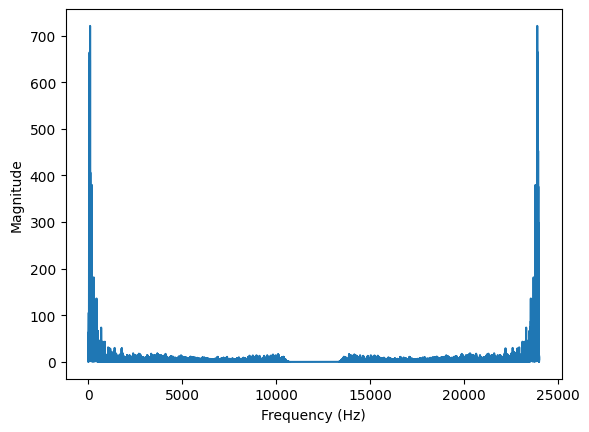

In [154]:
# Note that scipy returns complex values, so use .abs
#  to convert to magnitude scale
X_mag = np.abs(scipy.fft.fft(y))
f = np.linspace(0, sr, len(X_mag))  # frequency variable
plt.plot(f, X_mag)
plt.gca().set(xlabel="Frequency (Hz)", ylabel="Magnitude")
plt.show()

Plotting the signal in this way allows us to see both the high and low frequency components within the entire audio signal.

#### Short-Time Fourier Transform 🏃

Music signals change over time. We might have more low frequency elements when the drums are playing, and more high frequency elements when a singer is present. In the previous section, however, we just computed a single FFT for the entire signal. This means that our representation misses a lot of detail.

Instead, we often compute the **short-time Fourier transform (STFT)**. The STFT is simply the FFT computed consecutively over short sections of the same signal. We call these sections **frames** (sometimes also called **windows**). This means that the STFT is a function of both time, amplitude, and frequency.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR6HaWsSFTq_mu2QXZqLs4FNFSWMWLbuaXLxQus7cmkO0QGMliOjY-EeDHaq4J3iNlAjo8&usqp=CAU" width="400px"/>

We can compute the STFT using `librosa.stft`. We provide this with the audio signal, as well as a variety of additional parameters:
- `win_length`: the number of samples within every frame
- `hop_length` the number of samples between consecutive STFTs
- `n_fft`: the number of frequency bins within the output (equivalent to the total number of sinusoids)


The `win_length` and `hop_length` parameters affect how time is represented. Lowering them will increase the number of audio frames, as we compute more FFTs.

Meanwhile, `n_fft` effects how frequency is represented. Increasing it gives you **finer frequency resolution** (as we compute more frequency **bins**).

In [155]:
X_stft = librosa.stft(y, win_length=512, hop_length=256)

If we inspect the shape of the output, we can see that it contains 1025 frequency bins and 862 frames.

Try playing around with the arguments to `librosa.stft` and see how it changes the shape!

#### Creating Spectrograms 🎨

Now, we can put everything together and create our first spectrogram.

We extract the real valued components of the STFT and convert it to log scale (*note that we do this as the human perception of sound intensity is logarithmic in nature*):

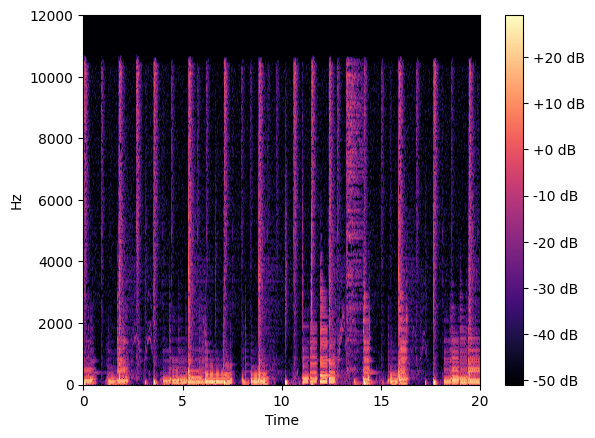

In [156]:
spect = librosa.amplitude_to_db(np.abs(X_stft))
librosa.display.specshow(spect, sr=sr, x_axis="time", y_axis="linear")
plt.colorbar(format="%+2.0f dB")
plt.show()

You might have noticed that our spectrograms **look very different** to both our text and MIDI sequences, and our waveforms. They are **no longer one-dimensional sequences**; instead, they are two-dimensional matrices! We might even say that they ***look a lot like images***! In fact, just as many state-of-the-art music generation models have simply used language models trained on MIDI, so have other models [used image generation models trained on spectrograms](https://arxiv.org/pdf/2409.02845)!

Some musicians have even experimented with *hiding images* inside the spectrogram of their recordings. When you listen to the recording, you probably wouldn't notice anything different. But when you convert it into a spectrogram...

In [157]:
ipd.HTML('''
<iframe width="560" height="315"
src="https://www.youtube.com/embed/M9xMuPWAZW8?t=332"
referrerpolicy="strict-origin-when-cross-origin"
</iframe>
''')

## Representing Images 🖼

When we work with images in machine learning contexts, we usually have to think about how to represent its height, width, and colour. Let's load an image in Python to show what we mean:


In [158]:
astronaut = skimage.data.astronaut()
print(astronaut.shape)

(512, 512, 3)


If we inspect the image, we can see that we have a 3 dimensional array.
- The first dimension (512) shows the number of rows, which correspond to the image's height in pixels.
- The second dimension (512) represents the number of columns, or the image's width in pixels.
- The third dimension (3) corresponds to the colour channels: Red, Green, and Blue (RGB).

So this image is a **512 x 512 pixel color image**, where each pixel has three values representing the intensity of red, green, and blue. Let's show the image:


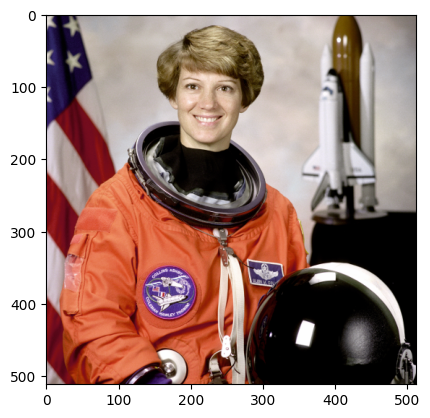

In [159]:
plt.imshow(astronaut)
plt.show()

### Image Manipulation and Pre-Processing

There are many different ways that we may want to **manipulate** and **pre-process** our image before using it as the input to a machine learning model.

#### Grayscale

To start with, we can consider the *colour* dimension. Notice how our colour image is three-dimensional: we have separate values for every pixel showing the amount of red, green, and blue within the image.

Sometimes in machine learning, we may not need to pass this information to the model. For instance, in object detection, we might only be interested in the *shapes and contours* of the objects in the image, and *not their colour*. Instead, we can convert our image to grayscale (or black-and-white).

We can use `skimage` to do this for us:

In [160]:
astronaut_gray = skimage.color.rgb2gray(astronaut)
print(astronaut_gray.shape)

(512, 512)


Notice how we've lost the third dimension of our array (sometimes called the *"channel dimension"*). Now we have a two-dimensional image, reprented as a 512 x 512 grid. Every value in this grid corresponds to the grayscale value of that pixel. Values of 0 are black; as this number increases, *more and more white* is added.

Let's show the transformed image:

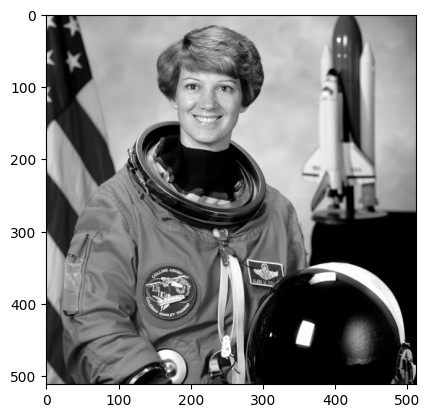

In [161]:
plt.imshow(astronaut_gray, cmap=plt.cm.gray)
plt.show()

#### Rescaling

Remember how our image is represented using 512 rows and columns of pixels? We can reduce this value by **rescaling** our image. Let's use `skimage` again. We'll rescale the image by a factor of four:


In [162]:
astronaut_rescale = skimage.transform.rescale(astronaut_gray, 0.25)
print(astronaut_rescale.shape)

(128, 128)


As you can see, we've now gone from 512 rows and columns of pixels down to 128. Let's see what effect this has had on the image:

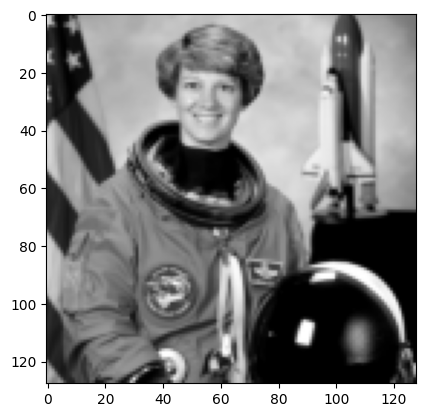

In [163]:
plt.imshow(astronaut_rescale, cmap=plt.cm.gray)
plt.show()

While the rescaling process did cause us to lose some of the detail from the original input, many of the objects and details are still clear.

Usually, when we reduce the number of pixels by rescaling, we call this process **downscaling**. Vice-versa, increasing the number of pixels is called **upscaling**. Both use different techniques.


#### Why Should you Preprocess? 🤔

Our initial image had `512 x 512 x 3 = 786432` individual values. After converting to grayscale, we had `512 x 512 = 262144` values. Finally, after rescaling, we cut this to `128 x 128 = 16384`. In other words, we cut the total number of pixels in half **48 times**, without losing too much detail in the process.

When we come to train a machine learning model, we will usually divide our full training dataset of images up into smaller **batches**. Every batch contains a small subset of the images in the dataset. Our model then learns from a single batch before moving onto the next one, until it has seen all of the images in the dataset. (We may then continue training from the first batch, starting what we call a new *epoch*).

By preprocessing our images, we are usually able to *fit more images* into a single batch. This can **reduce the time it takes to train our model** as well as **improve the stability** of the learning process. Preprocessing can also be used to standardize our dataset in cases where images *may have different sizes or resolutions*.


> **Did you know?** A comparable method to rescaling when working with audio is called **resampling**. When we resample audio, we change the **sample rate** and either *reduce* or *increase* the number of samples required to represent one second of audio. These processes are called - you guessed it! - **downsampling** and **upsampling**, respectively. Both are frequently used by machine learning scientists.

### Image Tokenization

Some models (for instance, [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) or CNNs) can work directly with images. In other cases (like transformers), we may first need to *convert our image* to a one-dimensional, discrete sequence of tokens, just as we did earlier with our text sequence.

Image tokenisation can be quite a complicated process. Unlike text, we are now dealing with continuous, multi-dimensional arrays. Fortunately, there are numerous libraries available to help make this process easier.



#### Tokenization with `TiTok`

One example of an image tokenizer is `TiTok`. This is a compact tokenizer that can represent a `256 x 256` image with **as few as 32 discrete tokens**.

The image below shows the results of encoding an image with `TiTok` to get a discrete, one-dimensional sequence of tokens, and then decoding this back to an image.

<img src="https://ravinkumar.com/GenAiGuidebook/_images/644afcf35e65f6d3c2213bda526e60771a7e1195c523bd09f7fa1dc2c52c224e.png" width="600px"/>

Remarkably, this `256 x 256` image was represented using just the following token sequence:

```
[2931, 2500, 2713,  432, 3197,  531, 3748, 2074,  533, 3694, 1659, 2498, 1346, 2523, 1638, 2947, 1907, 2265, 1857, 3371, 1638, 2109, 327, 2615, 3040,  146, 3507, 3215, 3454, 1822,  234, 2252]
```

### Extension: Representing Videos 📹

Many of the methods that are appropriate for preprocessing and representing images are also appropriate for working with **videos**, too. This is because videos are (essentially) just a succession of images played in sequence at a consistent rate.

The number of images per second is usually referred to as the **frame rate** (compare this to our audio sample rate from earlier). Typical frame rates in computer vision research are 24 and 30 frames per second.

## Summary 🤖🎹

In this notebook, we have explored ways we can **represent** differenet kinds of data. In particular, we have looked at *text*, *audio*, and *images*.

- **Text** can be represented as a one-dimensional, discrete, and ordered sequence of integer values, corresponding with the vocabulary of a model.
    - **Tokenization methods** can be used to control how text is converted into integer values.
- **Images** can be represented using numerical matrices, where individual values correspond with pixels.
    - **Videos** can be represented simply by stacking multiple images (frames) into a single input at a given *frame rate*
- **Audio** can be represented using MIDI, waveforms, and spectrograms.
    - MIDI is directly comparable to text, and can be used to train large language models on music content.
    - Waveforms are one-dimensional, continuous, and ordered sequences that express air pressure as a function of time.
    - Spectrograms are matrices, similar to **images**, which capture the time, frequency, and magnitude of an input.

Now we've explored the ways we can represent different kinds of data, the next stage is to look at how we can *use some of these representations* to train a model.